In [1]:
import numpy as np
import pandas as pd
import os
from load_img.baseimage import PETImage, normalize
from kmeans_segmentation import pca_kmeans_segmentation, apply_masks

#### Data from File

In [28]:
data_dir = 'data'
pet_files = [f for f in os.listdir(data_dir) if f.endswith('.pet.img') and not f.startswith('.')]
fname = pet_files[4]
fpath = os.path.join(data_dir,fname)
my_img = PETImage(filepath=fpath)
my_img.load_image()

File dimensions: (128,128,159,40)
Reading image data...


#### Segment Image

Clustering image voxels...
Created 10 masks of image


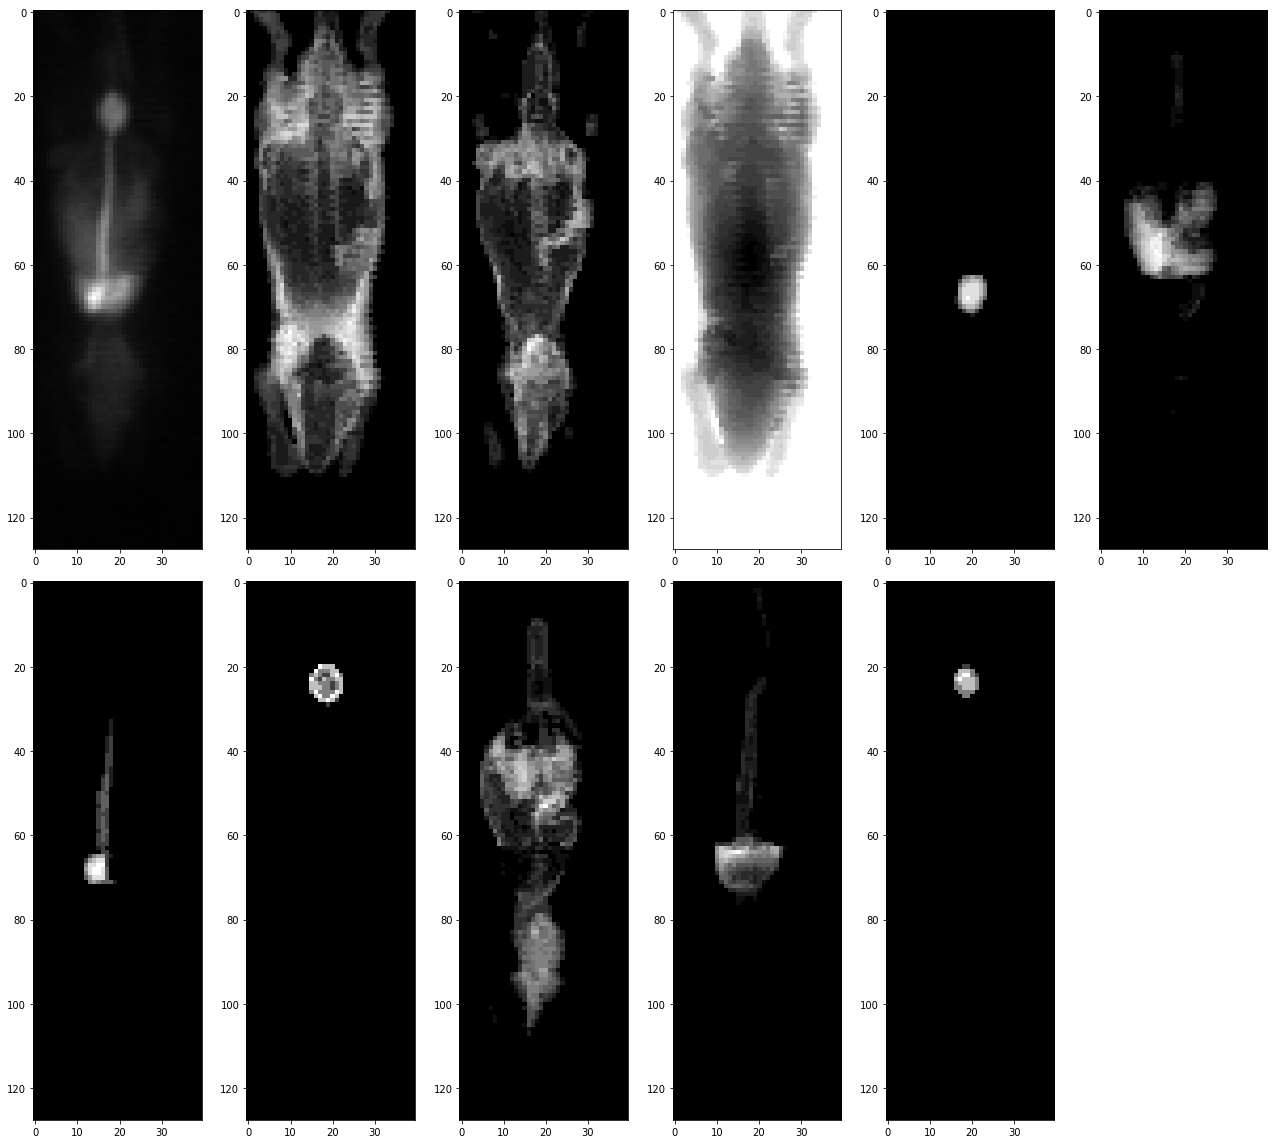

In [29]:
Ns = my_img.img_data.shape

# select the middle z=Ws[0],y=Ws[1],x=Ws[2] prism of each frame
Ws = (128,60,40)
roi_lims = [(int((N-W)/2),int((N+W)/2)) for N,W in zip(Ns,Ws)]

# select options for segmentation and run segmentation
print('Clustering image voxels...')
options = {
    'roi_lims' : roi_lims,
    'plot' : True,
    'fig_size' : (18, 16),
    'nfeatures' : 6,
    'nclusters' : 10
    }
masks, roi = pca_kmeans_segmentation(my_img,**options)

# done with original image data
my_img.unload_image()

#### apply masks to original ROI

In [30]:
new_rois = apply_masks(masks,roi)

#### plot total intensity of each segment

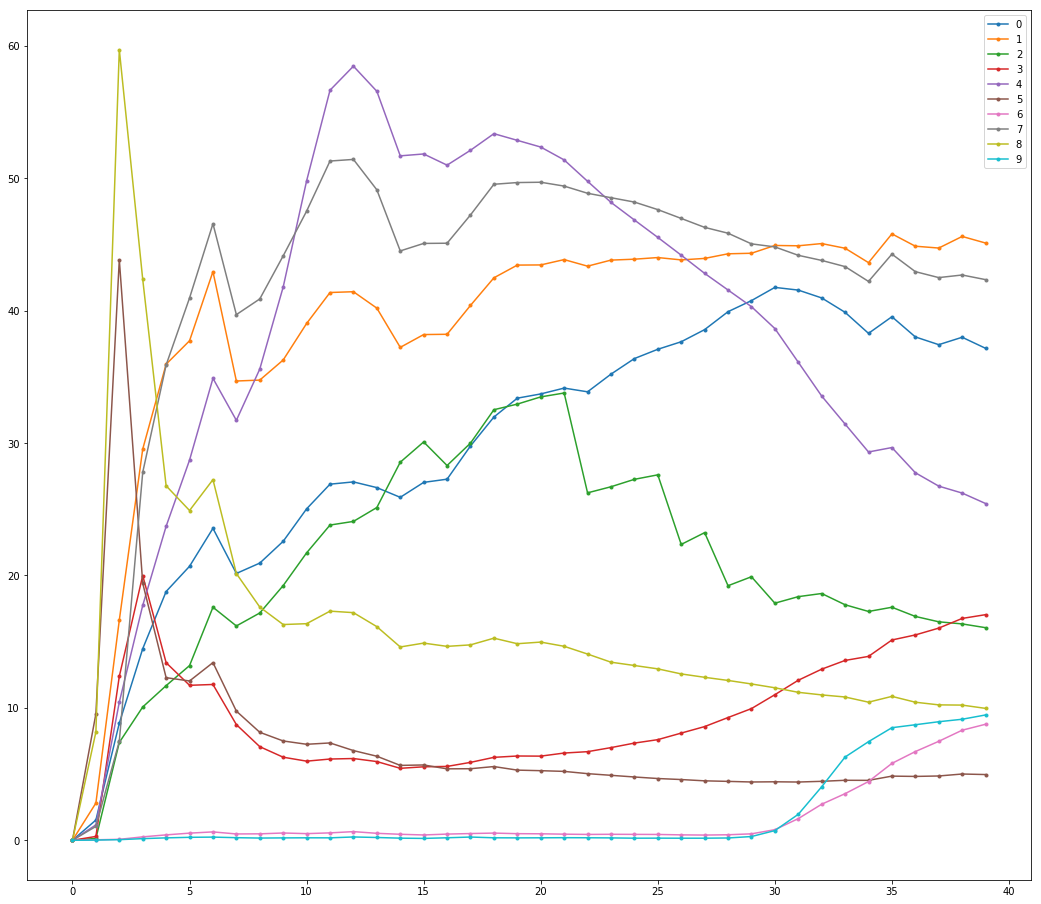

In [31]:
intensity_curves  = [mroi.reshape(Ws[0]*Ws[1]*Ws[2],Ns[-1]).sum(axis=0) for mroi in new_rois]
df = pd.DataFrame(data=np.stack(intensity_curves).T)
df.plot(figsize=(18, 16),marker='.')

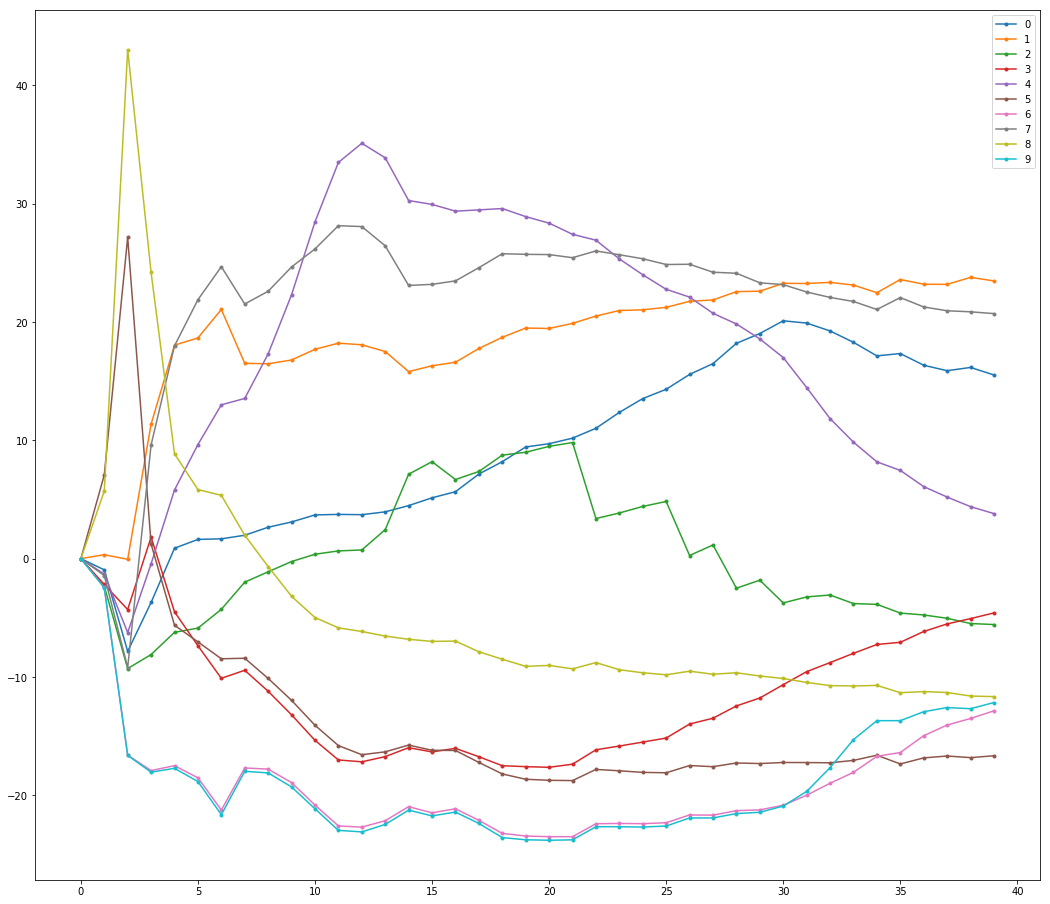

In [32]:
sdf = df.subtract(df.mean(axis=1),axis=0)
sdf.plot(figsize=(18, 16),marker='.')